<a href="https://colab.research.google.com/github/22f3000982/DL_genai_project/blob/main/notebooks/model1_scratch_tfidf_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader, TensorDataset

In [2]:
!pip install wandb --quiet

import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

import wandb

#Colab ke liye WB login
wandb.login()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 22f3000982 (22f3000982-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
WANDB_PROJECT = "2025-sep-dl-genai-project"
RUN_NAME = "model1_scratch_tfidf_logreg"

wandb.init(
    project=WANDB_PROJECT,
    name=RUN_NAME,
    config={
        "model": "tfidf_logreg_scratch",
        "test_size": 0.10,
        "max_features": 30000,
        "ngram_range": (1, 2),
        "C": 4.0,
        "random_state": 42
    }
)

config = wandb.config


In [4]:
train_df = pd.read_csv("/content/train (3).csv")

labels = ["anger", "fear", "joy", "sadness", "surprise"]
print(train_df.head())
print("Train shape:", train_df.shape)


   id                                               text  anger  fear  joy  \
0   0  the dentist that did the work apparently did a...      1     0    0   
1   1  i'm gonna absolutely ~~suck~~ be terrible duri...      0     1    0   
2   2  bridge: so leave me drowning calling houston, ...      0     1    0   
3   3  after that mess i went to see my now ex-girlfr...      1     1    0   
4   4  as he stumbled i ran off, afraid it might some...      0     1    0   

   sadness  surprise                    emotions  
0        1         0         ['anger' 'sadness']  
1        1         0          ['fear' 'sadness']  
2        1         0          ['fear' 'sadness']  
3        1         0  ['anger' 'fear' 'sadness']  
4        0         0                    ['fear']  
Train shape: (6827, 8)


In [5]:
def clean_text(text):
    text = str(text).lower()

    text = re.sub(r"http\S+", " ", text)

    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["clean_text"] = train_df["text"].apply(clean_text)
train_df[["text", "clean_text"]].head()


,text,clean_text
0,the dentist that did the work apparently did a...,the dentist that did the work apparently did a...
1,i'm gonna absolutely ~~suck~~ be terrible duri...,im gonna absolutely suck be terrible during my...
2,"bridge: so leave me drowning calling houston, ...",bridge so leave me drowning calling houston an...
3,after that mess i went to see my now ex-girlfr...,after that mess i went to see my now exgirlfri...
4,"as he stumbled i ran off, afraid it might some...",as he stumbled i ran off afraid it might someh...


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df["clean_text"],
    train_df[labels].values,
    test_size=config.test_size,
    random_state=config.random_state
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))


Train size: 6144
Val size: 683


In [7]:
vectorizer = TfidfVectorizer(
    max_features=config.max_features,
    ngram_range=(1, 2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

input_dim = X_train_tfidf.shape[1]
num_labels = len(labels)

print("TF-IDF Input dim:", input_dim)
print("Number of output labels:", num_labels)


TF-IDF Input dim: 30000
Number of output labels: 5


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_tfidf.toarray(),   dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32)

batch_size = 256

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor,   y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)


Using device: cuda


In [9]:
class TfidfMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_labels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)   # raw logits

hidden_dim = 256

model = TfidfMLP(input_dim, hidden_dim, num_labels).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


TfidfMLP(
  (fc1): Linear(in_features=30000, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)


In [10]:
num_epochs = 10
THRESH = 0.5

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    train_loss = total_loss / len(train_loader.dataset)

    # -------- VALIDATE --------
    model.eval()
    all_probs, all_targets = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu())
            all_targets.append(yb)

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    val_pred = (all_probs >= THRESH).astype(int)

    macro_f1 = f1_score(all_targets, val_pred, average="macro")
    micro_f1 = f1_score(all_targets, val_pred, average="micro")
    accuracy = accuracy_score(all_targets, val_pred)

    print(
        f"Epoch {epoch}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Macro F1: {macro_f1:.4f} | "
        f"Micro F1: {micro_f1:.4f} | "
        f"Accuracy: {accuracy:.4f}"
    )

    # ---------- W&B Logging (Standard Names) ----------
    wandb.log({
        "epoch": epoch,
        "loss": train_loss,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "accuracy": accuracy,
        "threshold": THRESH
    })

wandb.finish()


Epoch 1/10 | Train Loss: 0.6692 | Macro F1: 0.1459 | Micro F1: 0.4534 | Accuracy: 0.1230
Epoch 2/10 | Train Loss: 0.5819 | Macro F1: 0.1459 | Micro F1: 0.4534 | Accuracy: 0.1230
Epoch 3/10 | Train Loss: 0.5218 | Macro F1: 0.1540 | Micro F1: 0.4669 | Accuracy: 0.1274
Epoch 4/10 | Train Loss: 0.4583 | Macro F1: 0.1987 | Micro F1: 0.4940 | Accuracy: 0.1816
Epoch 5/10 | Train Loss: 0.3780 | Macro F1: 0.4027 | Micro F1: 0.6060 | Accuracy: 0.3075
Epoch 6/10 | Train Loss: 0.3017 | Macro F1: 0.5183 | Micro F1: 0.6833 | Accuracy: 0.4085
Epoch 7/10 | Train Loss: 0.2385 | Macro F1: 0.5720 | Micro F1: 0.7202 | Accuracy: 0.4671
Epoch 8/10 | Train Loss: 0.1888 | Macro F1: 0.6037 | Micro F1: 0.7397 | Accuracy: 0.5066
Epoch 9/10 | Train Loss: 0.1498 | Macro F1: 0.6812 | Micro F1: 0.7643 | Accuracy: 0.5520
Epoch 10/10 | Train Loss: 0.1203 | Macro F1: 0.7195 | Micro F1: 0.7795 | Accuracy: 0.5827


accuracy,▁▁▁▂▄▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▁▁
macro_f1,▁▁▁▂▄▆▆▇██
micro_f1,▁▁▁▂▄▆▇▇██
threshold,▁▁▁▁▁▁▁▁▁▁
accuracy,0.58272
epoch,10
loss,0.12031
macro_f1,0.71947
micro_f1,0.77947


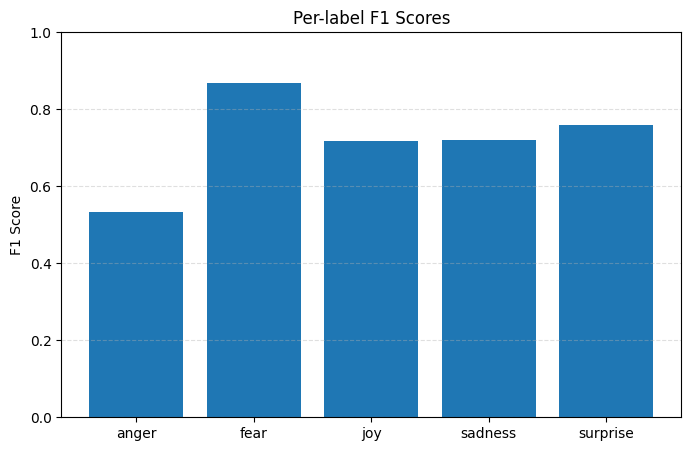

In [11]:
import matplotlib.pyplot as plt

emotion_names = labels
f1_values = [f1_score(all_targets[:, i], val_pred[:, i]) for i in range(len(labels))]

plt.figure(figsize=(8, 5))
plt.bar(emotion_names, f1_values)
plt.ylabel("F1 Score")
plt.title("Per-label F1 Scores")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()
